In [22]:
#%matplotlib notebook
# Do for the snapshots
from main import *
import numpy


MaxOmega=1e8
p=3
mu=8
alpha=0.001
directory="CSG_TwoTetra/al_0.001_mu_"+str(mu)+"_sig_1e7/1e1-1e8_100_el_25014_ord_3_POD_13_1e-6/Data/"
#MaxOmega=1e8
#p=3
#mu=100
#alpha=0.01

#directory="OCC_Gun_modelv2_nonsym_StainSt/al_"+str(alpha)+"_mu_1,"+str(mu)+"_sig_1.45e6,4.5e6/1e1-1e8_100_el_26657_ord_"+str(p)+"_POD_13_1e-6/Data/"
TensorArray = np.genfromtxt(directory+'Tensors.csv', dtype=complex, delimiter=', ')
N0 =          np.genfromtxt(directory+'N0.csv', dtype=float, delimiter=',')
Frequencies = np.genfromtxt(directory+'Frequencies.csv', dtype=float, delimiter=', ')
N=len(Frequencies)


uRtildestore = np.zeros((N,3))
uRstore = np.zeros((N,3))
uIstore = np.zeros((N,3))
uN0store = np.zeros((N,3))


In [23]:

#RIResultsFull,RtildeIResultsFull, N0IResultsFull, N0RResultsFull, N0RtildeResultsFull=main(directory,MaxOmega,Figures="On",FullRom="Full")    
RIResults,RtildeIResults, N0IResults, N0RResults, N0RtildeResults=main(directory,MaxOmega,Figures="Off",FullRom="Rom")    


print("finished")


Opening files from this path =  CSG_TwoTetra/al_0.001_mu_8_sig_1e7/1e1-1e8_100_el_25014_ord_3_POD_13_1e-6/Data/
Computing F measure Tilde
finished


In [24]:
angles="On"

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import time as mytime
from IPython.display import clear_output

from ipywidgets import interact,interactive,widgets
TensorArray = np.genfromtxt(directory+'Tensors.csv', dtype=complex, delimiter=', ')
N0 =          np.genfromtxt(directory+'N0.csv', dtype=float, delimiter=',')
Frequencies = np.genfromtxt(directory+'Frequencies.csv', dtype=float, delimiter=', ')

# Compute all eigenvalues
for n in range(N):
    Mlist = TensorArray[n,:]
    Mten = np.array([[Mlist[0], Mlist[1], Mlist[2]],[Mlist[3], Mlist[4], Mlist[5]],[Mlist[6], Mlist[7], Mlist[8]]])
    Rtilde = np.real(Mten)
    uRtilde,VRtilde=np.linalg.eig(Rtilde)
    uRtilde=np.sort((uRtilde))
    R =Rtilde-N0
    uR,VR=np.linalg.eig(R)
    uR=np.sort((uR))
    I = np.imag(Mten)
    uI,VI=np.linalg.eig(I)
    uI=np.sort(uI)
    uRtildestore[n,:]=uRtilde
    uRstore[n,:]=uR
    uIstore[n,:]=uI
    uN0,VN0=np.linalg.eig(N0)
    uN0=np.sort(uN0)
    uN0store[n,:]=uN0
    
limR=np.min(np.abs(uRstore))
limI=np.min(np.abs(uIstore))
limRtilde=np.min(np.abs(uRtildestore))

print(limR,limI,limRtilde)
print(1/limR,1/limI,1/limRtilde)
limR=1/100
limRtilde=1/100
limI=1/100


def ellipsoid(A,QA,sfactor):
    center = [0,0,0]

    U, s, rotation = np.linalg.svd(A)
    rotation=QA
    s=np.transpose(QA)@A@QA
    s=np.diag(s)
    # nb s are the singular values and s = |lambdda(A)| since A is square and normal   
    radii =1/np.sqrt(s*sfactor)
    radii =radii/np.max(radii)
    
    
    #print(radii,s)
    u = np.linspace(0.0, 2.0 * np.pi, 100)
    v = np.linspace(0.0, np.pi, 100)
    x = radii[0] * np.outer(np.cos(u), np.sin(v))
    y = radii[1] * np.outer(np.sin(u), np.sin(v))
    z = radii[2] * np.outer(np.ones_like(u), np.cos(v))
    for i in range(len(x)):
        for j in range(len(x)):
            [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], rotation) + center

    return x,y,z,radii

def plotmytenRI(n,sR,sI):
    clear_output(wait=True)
    Mlist = TensorArray[n,:]
    Mten = np.array([[Mlist[0], Mlist[1], Mlist[2]],[Mlist[3], Mlist[4], Mlist[5]],[Mlist[6], Mlist[7], Mlist[8]]])
    Rtilde = np.real(Mten)
    uRtilde,VRtilde=np.linalg.eig(Rtilde)
    uRtilde=np.sort(abs(uRtilde))
    print("Frequency under consideration is", Frequencies[n], "rad/s")
    I = np.imag(Mten)
    R = np.real(Mten)-N0
    
    # plot out R nb we look at the ellipsoid corresponding to |R|
    
    fig2=plt.figure(1,figsize=(10,5))
    ax2 = fig2.add_subplot(231, projection='3d')

    QRstore=RIResults["QRstore"]
    QR=np.zeros((3,3))
    QR=QRstore[n,:,:]
    x,y,z,radiiR = ellipsoid(-R,QR,sR)

    ax2.plot_wireframe(x, y, z,  rstride=4, cstride=4, color='r', alpha=0.2,label="-R")

    QIstore=RIResults["QIstore"]
    QI=np.zeros((3,3))
    QI=QIstore[n,:,:]
    #print(QR,QI,QR@np.transpose(QI))

    x,y,z,radiiI = ellipsoid(I,QI,sI)
    kvec=max(max(radiiR),max(radiiI))*RIResults["RIkthetavec"][n,:]/RIResults["MinAnglestoreRI"][n]
    #print(kvec)
    ax2.plot_wireframe(x, y, z,  rstride=4, cstride=4, color='b', alpha=0.2,label="I")
    ax2.plot([0,kvec[0]],[0,kvec[1]],[0,kvec[2]],lw=3)
    #ax2.axis("equal")
    ax2.set_zlim(-1, 1)
    ax2.set_ylim(-1, 1)
    ax2.set_xlim(-1, 1)
    
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_zlabel('z')
    
    ax2.legend()
    #ax2.axes.set_xlim3d(left=-1/limR, right=1/limR) 
    #ax2.axes.set_ylim3d(bottom=-1/limR, top=1/limR) 
    #ax2.axes.set_zlim3d(bottom=-1/limR, top=1/limR) 
    ax3 = fig2.add_subplot(232)
    ax3.semilogx(Frequencies,uRstore[:,0],label=r'$\lambda_1({\cal R})$')
    ax3.semilogx(Frequencies,uRstore[:,1],label=r'$\lambda_2({\cal R})$')
    ax3.semilogx(Frequencies,uRstore[:,2],label=r'$\lambda_3({\cal R})$')
    ax3.semilogx(Frequencies[n],uRstore[n,0],'x',label=r'$\lambda_1({\cal R})$')
    ax3.semilogx(Frequencies[n],uRstore[n,1],'x',label=r'$\lambda_2({\cal R})$')
    ax3.semilogx(Frequencies[n],uRstore[n,2],'x',label=r'$\lambda_3({\cal R})$')
    
    ax5 = fig2.add_subplot(233)
    ax5.semilogx(Frequencies,uIstore[:,0],label=r'$\lambda_1({\cal I})$')
    ax5.semilogx(Frequencies,uIstore[:,1],label=r'$\lambda_2({\cal I})$')
    ax5.semilogx(Frequencies,uIstore[:,2],label=r'$\lambda_3({\cal I})$')
    ax5.semilogx(Frequencies[n],uIstore[n,0],'x',label=r'$\lambda_1({\cal I})$')
    ax5.semilogx(Frequencies[n],uIstore[n,1],'x',label=r'$\lambda_2({\cal I})$')
    ax5.semilogx(Frequencies[n],uIstore[n,2],'x',label=r'$\lambda_3({\cal I})$')
    ax5.legend()

    ax3.legend()
    if angles=="On":
        MinAnglestoreRI=RIResults["MinAnglestoreRI"]
        AnglestoreRIfmeasapprxconstsortedmin=np.fmin(RIResults["AnglestoreRIfmeasapprxconstsortedmaxdiff_min"],
                                                     RIResults["AnglestoreRIfmeasapprxconstsortedmindiff_min"])
        AnglestoreRIfmeasapprxconstsortedmax=np.fmax(RIResults["AnglestoreRIfmeasapprxconstsortedmaxdiff_max"],RIResults["AnglestoreRIfmeasapprxconstsortedmindiff_max"])


        AnglestoreRIcommeasapprxconstsortedmin=np.fmin(RIResults["AnglestoreRIcommeasapprxconstsortedmaxdiff_min"],RIResults["AnglestoreRIcommeasapprxconstsortedmindiff_min"])
        AnglestoreRIcommeasapprxconstsortedmax=np.fmax(RIResults["AnglestoreRIcommeasapprxconstsortedmaxdiff_min"],RIResults["AnglestoreRIcommeasapprxconstsortedmindiff_min"])

        dFMinAnglestoreRI = RIResults["dFMinAnglestoreRI"]
        #fig=plt.figure()
        
        ax6 = fig2.add_subplot(234)
        ax6.semilogx(Frequencies,MinAnglestoreRI,label=r'$d_R({\cal R},{\cal I})$')
        ax6.semilogx(Frequencies,dFMinAnglestoreRI/np.sqrt(2),label=r'$d_F({\cal R},{\cal I})/\sqrt{2}$')
        ax6.semilogx(Frequencies,AnglestoreRIfmeasapprxconstsortedmin,label=r'$\theta(d_E({\cal R},{\cal I}))$ LB')

        ax6.semilogx(Frequencies,AnglestoreRIcommeasapprxconstsortedmin,label=r'$\theta(d_C({\cal R},{\cal I}))$ LB')
        ax6.semilogx(Frequencies[n],MinAnglestoreRI[n],'x',label=r'$d_R({\cal R},{\cal I})$')

        ax6.set_xlabel(r'$\omega$ [rad/s]')
        ax6.set_ylabel(r'$\theta$ [rad]')
        ax6.legend()
    fig2.tight_layout()
    n+=1
    return fig2,n

def plotellipsoidsonly(n,sR,sI):    
    Mlist = TensorArray[n,:]
    Mten = np.array([[Mlist[0], Mlist[1], Mlist[2]],[Mlist[3], Mlist[4], Mlist[5]],[Mlist[6], Mlist[7], Mlist[8]]])
    Rtilde = np.real(Mten)
    uRtilde,VRtilde=np.linalg.eig(Rtilde)
    uRtilde=np.sort(abs(uRtilde))
    print("Frequency under consideration is", Frequencies[n], "rad/s")
    I = np.imag(Mten)
    R = np.real(Mten)-N0
    
    # plot out R nb we look at the ellipsoid corresponding to |R|
    
    fig2=plt.figure(1,figsize=(6,3))
    ax2 = fig2.add_subplot(111, projection='3d')

    QRstore=RIResults["QRstore"]
    QR=np.zeros((3,3))
    QR=QRstore[n,:,:]
    x,y,z,radiiR = ellipsoid(-R,QR,sR)

    ax2.plot_wireframe(x, y, z,  rstride=4, cstride=4, color='r', alpha=0.2,label="-R")

    QIstore=RIResults["QIstore"]
    QI=np.zeros((3,3))
    QI=QIstore[n,:,:]
    #print(QR,QI,QR@np.transpose(QI))

    x,y,z,radiiI = ellipsoid(I,QI,sI)
    kvec=max(max(radiiR),max(radiiI))*RIResults["RIkthetavec"][n,:]/RIResults["MinAnglestoreRI"][n]
    #print(kvec)
    ax2.plot_wireframe(x, y, z,  rstride=4, cstride=4, color='b', alpha=0.2,label="I")
    ax2.plot([0,kvec[0]],[0,kvec[1]],[0,kvec[2]],lw=3)
    #ax2.axis("equal")
    ax2.set_zlim(-1, 1)
    ax2.set_ylim(-1, 1)
    ax2.set_xlim(-1, 1)
    
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_zlabel('z')
    ax2.zaxis.labelpad=-0.7
    ax2.legend()
    fig2.tight_layout()
    

2.329529038325359e-15 1.3034479606817639e-11 1.927093927452063e-10
429271317741922.3 76719595270.75815 5189160661.837409


Frequency under consideration is 4862.601580065353 rad/s


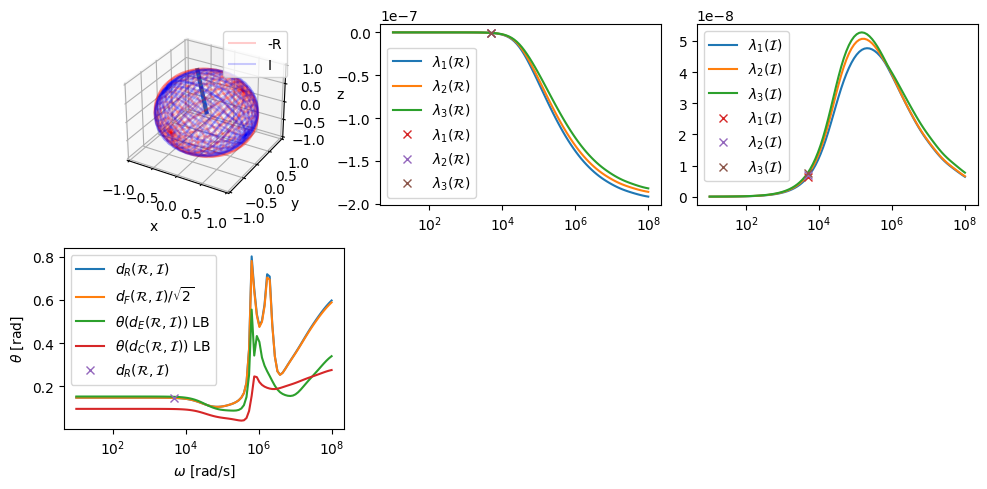

KeyboardInterrupt: 

In [26]:
#interact( plotmytenRI, n=widgets.IntSlider(min=0, max=N-1, step=1, value=10));
sR=1
sI=1
for n in range(N-1):
    #clear_output(wait=True)
    fig2=plotmytenRI(n,sR,sI)
    #plt.show()
    plt.pause(.5)
  

Frequency under consideration is 50.9413801481638 rad/s


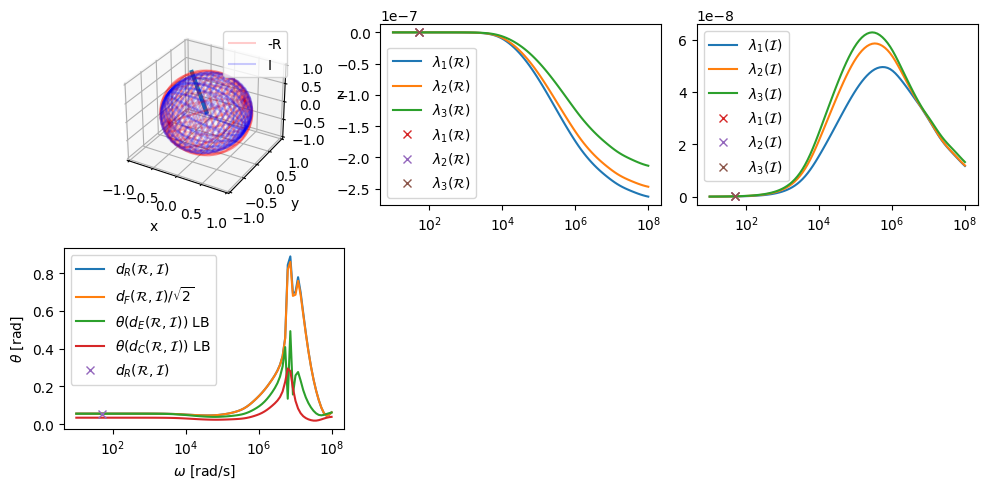

In [14]:
 fig2=plotmytenRI(10,sR,sI)

Frequency under consideration is 22.5701971963392 rad/s


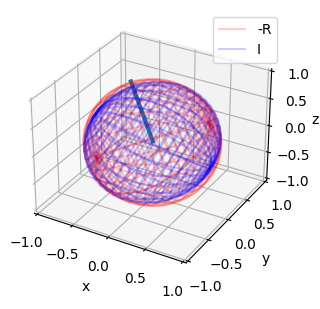

In [16]:
n=5
fig2=plotellipsoidsonly(n,sR,sI)
plt.savefig("CSG_TwoTetra_R_and_I_ellipsoids_omega_"+str(Frequencies[n])+".pdf")
plt.show()

In [63]:
6280291/1e7


0.6280291

In [10]:
#Frequencies = np.genfromtxt(directory+'Frequencies.csv', dtype=float, delimiter=', ')

def plotmytenRtildeI(n):
    Frequencies = np.genfromtxt(directory+'Frequencies.csv', dtype=float, delimiter=', ')

    Mlist = TensorArray[n,:]
    Mten = np.array([[Mlist[0], Mlist[1], Mlist[2]],[Mlist[3], Mlist[4], Mlist[5]],[Mlist[6], Mlist[7], Mlist[8]]])
    Rtilde = np.real(Mten)
    uRtilde,VRtilde=np.linalg.eig(Rtilde)
    uRtilde=np.sort(abs(uRtilde))
    print("Frequency under consideration is", Frequencies[n], "rad/s")
    I = np.imag(Mten)
    R = np.real(Mten)-N0

#   plot out Rtilde nb we look at the ellipsoid corresponding to Rtilde*Rtilde^T
    fig=plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(131, projection='3d')
    x,y,z = ellipsoid(Rtilde)
    
    ax1.plot_wireframe(x, y, z,  rstride=4, cstride=4, color='r', alpha=0.2, label=r'$\tilde{\cal R}$')    
    x,y,z = ellipsoid(I)
    ax1.plot_wireframe(x, y, z,  rstride=4, cstride=4, color='b', alpha=0.2, label=r'${\cal I}$')    
    
    ax1.legend()
    ax1.axis("equal")
    ax2 = fig.add_subplot(132)
    ax2.semilogx(Frequencies,uRtildestore[:,0],label=r'$\lambda_1(\tilde{\cal R})$')
    ax2.semilogx(Frequencies,uRtildestore[:,1],label=r'$\lambda_2(\tilde{\cal R})$')
    ax2.semilogx(Frequencies,uRtildestore[:,2],label=r'$\lambda_3(\tilde{\cal R})$')
    ax2.semilogx(Frequencies[n],uRtildestore[n,0],'x',label=r'$\lambda_1(\tilde{\cal R})$')
    ax2.semilogx(Frequencies[n],uRtildestore[n,1],'x',label=r'$\lambda_2(\tilde{\cal R})$')
    ax2.semilogx(Frequencies[n],uRtildestore[n,2],'x',label=r'$\lambda_3(\tilde{\cal R})$')
    
    ax2.legend()
    
    ax5 = fig.add_subplot(133)
    ax5.semilogx(Frequencies,uIstore[:,0],label=r'$\lambda_1({\cal I})$')
    ax5.semilogx(Frequencies,uIstore[:,1],label=r'$\lambda_2({\cal I})$')
    ax5.semilogx(Frequencies,uIstore[:,2],label=r'$\lambda_3({\cal I})$')
    ax5.semilogx(Frequencies[n],uIstore[n,0],'x',label=r'$\lambda_1({\cal I})$')
    ax5.semilogx(Frequencies[n],uIstore[n,1],'x',label=r'$\lambda_2({\cal I})$')
    ax5.semilogx(Frequencies[n],uIstore[n,2],'x',label=r'$\lambda_3({\cal I})$')
    ax5.legend()
    
    
    #ax4.axes.set_xlim3d(left=-1/limI, right=1/limI) 
    #ax4.axes.set_ylim3d(bottom=-1/limI, top=1/limI) 
    #ax4.axes.set_zlim3d(bottom=-1/limI, top=1/limI) 
    ax5 = fig.add_subplot(133)
    ax5.semilogx(Frequencies,uIstore[:,0],label=r'$\lambda_1({\cal I})$')
    ax5.semilogx(Frequencies,uIstore[:,1],label=r'$\lambda_2({\cal I})$')
    ax5.semilogx(Frequencies,uIstore[:,2],label=r'$\lambda_3({\cal I})$')
    ax5.semilogx(Frequencies[n],uIstore[n,0],'x',label=r'$\lambda_1({\cal I})$')
    ax5.semilogx(Frequencies[n],uIstore[n,1],'x',label=r'$\lambda_2({\cal I})$')
    ax5.semilogx(Frequencies[n],uIstore[n,2],'x',label=r'$\lambda_3({\cal I})$')
    ax5.legend()
    
    fig.tight_layout()
    plt.show()
    
    if angles=="On":
        Frequencies=RtildeIResults["Frequencies"]
        MinAnglestoreRtildeI=RtildeIResults["MinAnglestoreRtildeI"]
        dFMinAnglestoreRtildeI = RtildeIResults["dFMinAnglestoreRtildeI"]
        AnglestoreRtildeIfmeasapprxconstsortedmin=np.fmin(RtildeIResults["AnglestoreRtildeIfmeasapprxconstsortedmaxdiff_min"],RtildeIResults["AnglestoreRtildeIfmeasapprxconstsortedmindiff_min"])
        AnglestoreRtildeIfmeasapprxconstsortedmax=np.fmax(RtildeIResults["AnglestoreRtildeIfmeasapprxconstsortedmaxdiff_max"],RtildeIResults["AnglestoreRtildeIfmeasapprxconstsortedmindiff_max"])

        AnglestoreRtildeIcommeasapprxconstsortedmin=np.fmin(RtildeIResults["AnglestoreRtildeIcommeasapprxconstsortedmaxdiff_min"],RtildeIResults["AnglestoreRtildeIcommeasapprxconstsortedmindiff_max"])
        AnglestoreRtildeIcommeasapprxconstsortedmax=np.fmax(RtildeIResults["AnglestoreRtildeIcommeasapprxconstsortedmaxdiff_max"],RtildeIResults["AnglestoreRtildeIcommeasapprxconstsortedmindiff_min"])

        fig=plt.figure()
        plt.semilogx(Frequencies,MinAnglestoreRtildeI,label=r'$d_R(\tilde{\cal R},{\cal I})$')
        plt.semilogx(Frequencies,dFMinAnglestoreRtildeI/np.sqrt(2),label=r'$d_F(\tilde{\cal R},{\cal I})/\sqrt{2}$')
        plt.semilogx(Frequencies,AnglestoreRtildeIfmeasapprxconstsortedmin,'-x',label=r'$\theta(d_E(\tilde{\cal R},{\cal I}))$ LB')

        plt.semilogx(Frequencies,AnglestoreRtildeIcommeasapprxconstsortedmin,'-x',label=r'$\theta(d_C(\tilde{\cal R},{\cal I}))$ LB ')
        plt.semilogx(Frequencies[n],MinAnglestoreRtildeI[n],label=r'$d_R(\tilde{\cal R},{\cal I})$')
    

        plt.xlabel(r'$\omega$ [rad/s]')
        plt.ylabel(r'$\theta$ [rad]')
        plt.legend()
        


In [11]:

interact( plotmytenRtildeI, n=widgets.IntSlider(min=0, max=N-1, step=1, value=10));

In [4]:
def plotmytenN0I(n):
    Frequencies = np.genfromtxt(directory+'Frequencies.csv', dtype=float, delimiter=', ')

    Mlist = TensorArray[n,:]
    Mten = np.array([[Mlist[0], Mlist[1], Mlist[2]],[Mlist[3], Mlist[4], Mlist[5]],[Mlist[6], Mlist[7], Mlist[8]]])
    Rtilde = np.real(Mten)
    uRtilde,VRtilde=np.linalg.eig(Rtilde)
    uRtilde=np.sort(abs(uRtilde))
    print("Frequency under consideration is", Frequencies[n], "rad/s")
    I = np.imag(Mten)
    R = np.real(Mten)-N0

#   plot out Rtilde nb we look at the ellipsoid corresponding to Rtilde*Rtilde^T
    fig=plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(131, projection='3d')
    x,y,z = ellipsoid(N0)
    
    ax1.plot_wireframe(x, y, z,  rstride=4, cstride=4, color='r', alpha=0.2, label=r'${\cal N}^{(0)}$')    
    x,y,z = ellipsoid(I)
    ax1.plot_wireframe(x, y, z,  rstride=4, cstride=4, color='b', alpha=0.2, label=r'${\cal I}$')    
    
    ax1.legend()
    ax1.axis("equal")
    ax2 = fig.add_subplot(132)
    ax2.semilogx(Frequencies,uN0store[:,0],label=r'$\lambda_1({\cal N}^{(0)})$')
    ax2.semilogx(Frequencies,uN0store[:,1],label=r'$\lambda_2({\cal N}^{(0)})$')
    ax2.semilogx(Frequencies,uN0store[:,2],label=r'$\lambda_3({\cal N}^{(0)})$')
    ax2.semilogx(Frequencies[n],uN0store[n,0],'x',label=r'$\lambda_1({\cal N}^{(0)})$')
    ax2.semilogx(Frequencies[n],uN0store[n,1],'x',label=r'$\lambda_2({\cal N}^{(0)})$')
    ax2.semilogx(Frequencies[n],uN0store[n,2],'x',label=r'$\lambda_3({\cal N}^{(0)})$')
    
    ax2.legend()
    
    ax5 = fig.add_subplot(133)
    ax5.semilogx(Frequencies,uIstore[:,0],label=r'$\lambda_1({\cal I})$')
    ax5.semilogx(Frequencies,uIstore[:,1],label=r'$\lambda_2({\cal I})$')
    ax5.semilogx(Frequencies,uIstore[:,2],label=r'$\lambda_3({\cal I})$')
    ax5.semilogx(Frequencies[n],uIstore[n,0],'x',label=r'$\lambda_1({\cal I})$')
    ax5.semilogx(Frequencies[n],uIstore[n,1],'x',label=r'$\lambda_2({\cal I})$')
    ax5.semilogx(Frequencies[n],uIstore[n,2],'x',label=r'$\lambda_3({\cal I})$')
    ax5.legend()
    
    
    #ax4.axes.set_xlim3d(left=-1/limI, right=1/limI) 
    #ax4.axes.set_ylim3d(bottom=-1/limI, top=1/limI) 
    #ax4.axes.set_zlim3d(bottom=-1/limI, top=1/limI) 
    ax5 = fig.add_subplot(133)
    ax5.semilogx(Frequencies,uIstore[:,0],label=r'$\lambda_1({\cal I})$')
    ax5.semilogx(Frequencies,uIstore[:,1],label=r'$\lambda_2({\cal I})$')
    ax5.semilogx(Frequencies,uIstore[:,2],label=r'$\lambda_3({\cal I})$')
    ax5.semilogx(Frequencies[n],uIstore[n,0],'x',label=r'$\lambda_1({\cal I})$')
    ax5.semilogx(Frequencies[n],uIstore[n,1],'x',label=r'$\lambda_2({\cal I})$')
    ax5.semilogx(Frequencies[n],uIstore[n,2],'x',label=r'$\lambda_3({\cal I})$')
    ax5.legend()
    
    fig.tight_layout()
    plt.show()
    
    if angles=="On":
        
        Frequencies=N0IResults["Frequencies"]
        MinAnglestoreN0I=N0IResults["MinAnglestoreN0I"]
        AnglestoreN0Ifmeasapprxconstsortedmin=np.fmin(N0IResults["AnglestoreN0Ifmeasapprxconstsortedmaxdiff_min"],N0IResults["AnglestoreN0Ifmeasapprxconstsortedmindiff_min"])
        AnglestoreN0Ifmeasapprxconstsortedmax=np.fmax(N0IResults["AnglestoreN0Ifmeasapprxconstsortedmaxdiff_max"],N0IResults["AnglestoreN0Ifmeasapprxconstsortedmindiff_max"])

        AnglestoreN0Icommeasapprxconstsortedmin=np.fmin(N0IResults["AnglestoreN0Icommeasapprxconstsortedmaxdiff_min"],N0IResults["AnglestoreN0Icommeasapprxconstsortedmindiff_min"])
        AnglestoreN0Icommeasapprxconstsortedmax=np.fmax(N0IResults["AnglestoreN0Icommeasapprxconstsortedmaxdiff_max"],N0IResults["AnglestoreN0Icommeasapprxconstsortedmindiff_max"])


        dFMinAnglestoreN0I = N0IResults["dFMinAnglestoreN0I"]
        fig=plt.figure()
        plt.semilogx(Frequencies,MinAnglestoreN0I,label=r'$d_R({\cal N}^{(0)},{\cal I})$')
        plt.semilogx(Frequencies,dFMinAnglestoreN0I/np.sqrt(2),label=r'$d_F({\cal N}^{(0)},{\cal I})/\sqrt{2}$')
        plt.semilogx(Frequencies,AnglestoreN0Ifmeasapprxconstsortedmin,'x-',label=r'$\theta(d_E({\cal N}^{(0)},{\cal I}))$ LB')

        plt.semilogx(Frequencies,AnglestoreN0Icommeasapprxconstsortedmin,'x-',label=r'$\theta(d_C({\cal N}^{(0)},{\cal I}))$ LB ')


        plt.xlabel(r'$\omega$ [rad/s]')
        plt.ylabel(r'$\theta$ [rad]')
        plt.legend()
        

In [5]:
interact( plotmytenN0I, n=widgets.IntSlider(min=0, max=N-1, step=1, value=10));

interactive(children=(IntSlider(value=10, description='n', max=99), Output()), _dom_classes=('widget-interact'…